### Notebook for the generation of an annotated manifold with `scANVI` 

- **Developed by:** Carlos Talavera-López Ph.D
- **Institute of Systems Immunology (WüSI) - JMU-Würzburg**
- v230608

### Import required modules

In [1]:
import anndata
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
from SCCAF import SCCAF_assessment, plot_roc
from scib_metrics.benchmark import Benchmarker

### Set up working environment

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.8.0
scanpy      1.9.3
-----
PIL                 9.4.0
SCCAF               NA
absl                NA
appnope             0.1.3
asttokens           NA
attr                23.1.0
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
cffi                1.15.1
chex                0.1.6
colorama            0.4.6
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.6
decorator           5.1.1
executing           1.2.0
h5py                3.8.0
hypergeom_ufunc     NA
igraph              0.10.4
importlib_resources NA
invgauss_ufunc      NA
ipykernel           6.15.0
ipywidgets          8.0.6
jax                 0.4.13
jaxlib              0.4.13
jedi                0.18.2
joblib              1.2.0
kiwisolver          1.4.4
leidenalg           0.9.1
llvmlite            0.39.1
louvain             0.8.0
matplotlib          3.7.1
ml_dtypes           0.2.0
mpl_toolkits        NA
natsort             8.3.1
nbinom_ufun

In [3]:
warnings.simplefilter(action = 'ignore')
scvi.settings.seed = 1712
%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}
%config InlineBackend.figure_format = 'retina'
torch.set_float32_matmul_precision('medium')

NameError: name 'scvi' is not defined

In [4]:
arches_params = dict(
    use_layer_norm = "both",
    use_batch_norm = "none",
    encode_covariates = True,
    dropout_rate = 0.2,
    n_layers = 3,
)

### Read in Healthy data

In [5]:
epith_mixed = sc.read_h5ad('../../../data/Epithelial_Mixed_ctl230608_states.raw.h5ad')
epith_mixed

AnnData object with n_obs × n_vars = 12256 × 27208
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', '_scvi_batch', '_scvi_labels', 'IAV_score', 'group', 'C_scANVI', 'cell_type', 'leiden', 'leiden_states', 'seed_labels', 'Viral_score', 'C_scANVI_v2', 'mixed_states'
    var: 'mt', 'ribo', 'n_cells_by_counts-V1', 'mean_counts-V1', 'pct_dropout_by_counts-V1', 'total_counts-V1', 'n_cells_by_counts-V2', 'mean_counts-V2', 'pct_dropout_by_counts-V2', 'total_counts-V2', 'n_cells_by_counts-V3', 'mean_counts-V3', 'pct_dropout_by_counts-V3', 'total_counts-V3', 'n_cells_by_counts-V4', 'mean_counts-V4', 'pct_dropout_by_counts-V4', 'total_counts-V4', '

In [6]:
epith_mixed.obs['C_scANVI_v2'].cat.categories

Index(['Mixed_11', 'Mixed_12', 'Mixed_13', 'Mixed_16'], dtype='object')

In [7]:
epith_mixed.obs['mixed_states'].cat.categories

Index(['Goblet_STEAP4+', 'Club_DHRS9+', 'iavEpi', 'Basal_SERPINE1+',
       'Basal_SERPINE2+', 'Goblet_RARRES1+', 'iavAT2_lip', 'Basal_IGFBP6+',
       'iavClub_SAA1+', 'SupraB_KRT16+'],
      dtype='object')

In [ ]:
epith_mixed.obs['donor'].cat.categories

- Visualise corrected dataset

In [ ]:
sc.pp.neighbors(epith_mixed, use_rep = "X_scANVI", n_neighbors = 50, metric = 'minkowski')
sc.tl.umap(epith_mixed, min_dist = 0.3, spread = 3, random_state = 1712)
sc.pl.umap(epith_mixed, frameon = False, color = ['group', 'disease', 'infection', 'C_scANVI', 'C_scANVI_v2', 'seed_labels', 'donor', 'bd_rhapsody', 'illumina_stimunr'], size = 2, legend_fontsize = 5, ncols = 4)

In [ ]:
sc.pl.umap(epith_mixed, frameon = False, color = ['SMK', 'n_genes', 'doublet_scores', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_counts', 'sample_group', 'IAV_score', 'Viral_score'], size = 2, legend_fontsize = 5, ncols = 4, cmap = 'plasma')

### Compute integration metrics

In [ ]:
bm = Benchmarker(
    epith_mixed,
    batch_key = ["donor"],
    label_key = "C_scANVI_v2",
    embedding_obsm_keys = ["X_pca", "X_scVI", "X_scANVI"],
    n_jobs = -1,
)
bm.benchmark()

In [ ]:
bm.plot_results_table(min_max_scale = False)

### Clustering manifold for Mixed cell states identification

In [ ]:
sc.tl.leiden(epith_mixed, resolution = 1, random_state = 1712)
sc.pl.umap(epith_mixed, frameon = False, color = ['leiden', 'C_scANVI', 'C_scANVI_v2', 'group'], size = 2, legend_fontsize = 5, ncols = 4)

In [ ]:
y_prob, y_pred, y_test, clf, cvsm, acc = SCCAF_assessment(epith_mixed.X, epith_mixed.obs['leiden'], n = 300)
plot_roc(y_prob, y_test, clf, cvsm = cvsm, acc = acc)
plt.rcParams["figure.figsize"] = (16,6)
plt.show()

### Annotate clusters based on marker genes WRST

In [8]:
epith_mixed_log = epith_mixed.copy()
epith_mixed_log

AnnData object with n_obs × n_vars = 12256 × 27208
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', '_scvi_batch', '_scvi_labels', 'IAV_score', 'group', 'C_scANVI', 'cell_type', 'leiden', 'leiden_states', 'seed_labels', 'Viral_score', 'C_scANVI_v2', 'mixed_states'
    var: 'mt', 'ribo', 'n_cells_by_counts-V1', 'mean_counts-V1', 'pct_dropout_by_counts-V1', 'total_counts-V1', 'n_cells_by_counts-V2', 'mean_counts-V2', 'pct_dropout_by_counts-V2', 'total_counts-V2', 'n_cells_by_counts-V3', 'mean_counts-V3', 'pct_dropout_by_counts-V3', 'total_counts-V3', 'n_cells_by_counts-V4', 'mean_counts-V4', 'pct_dropout_by_counts-V4', 'total_counts-V4', '

In [9]:
sc.pp.normalize_total(epith_mixed_log, target_sum = 1e6, exclude_highly_expressed = True)
sc.pp.log1p(epith_mixed_log)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['ACTB', 'BPIFA1', 'MT-CO1', 'MT-CO2', 'MT-CO3', 'MT-ND2', 'MT-ND3', 'NC_026431.1', 'NC_026432.1', 'NC_026433.1', 'NC_026434.1', 'NC_026435.1', 'NC_026436.1', 'NC_026437.1', 'NC_026438.1', 'SCGB1A1', 'SCGB3A1', 'SLPI']
    finished (0:00:00)


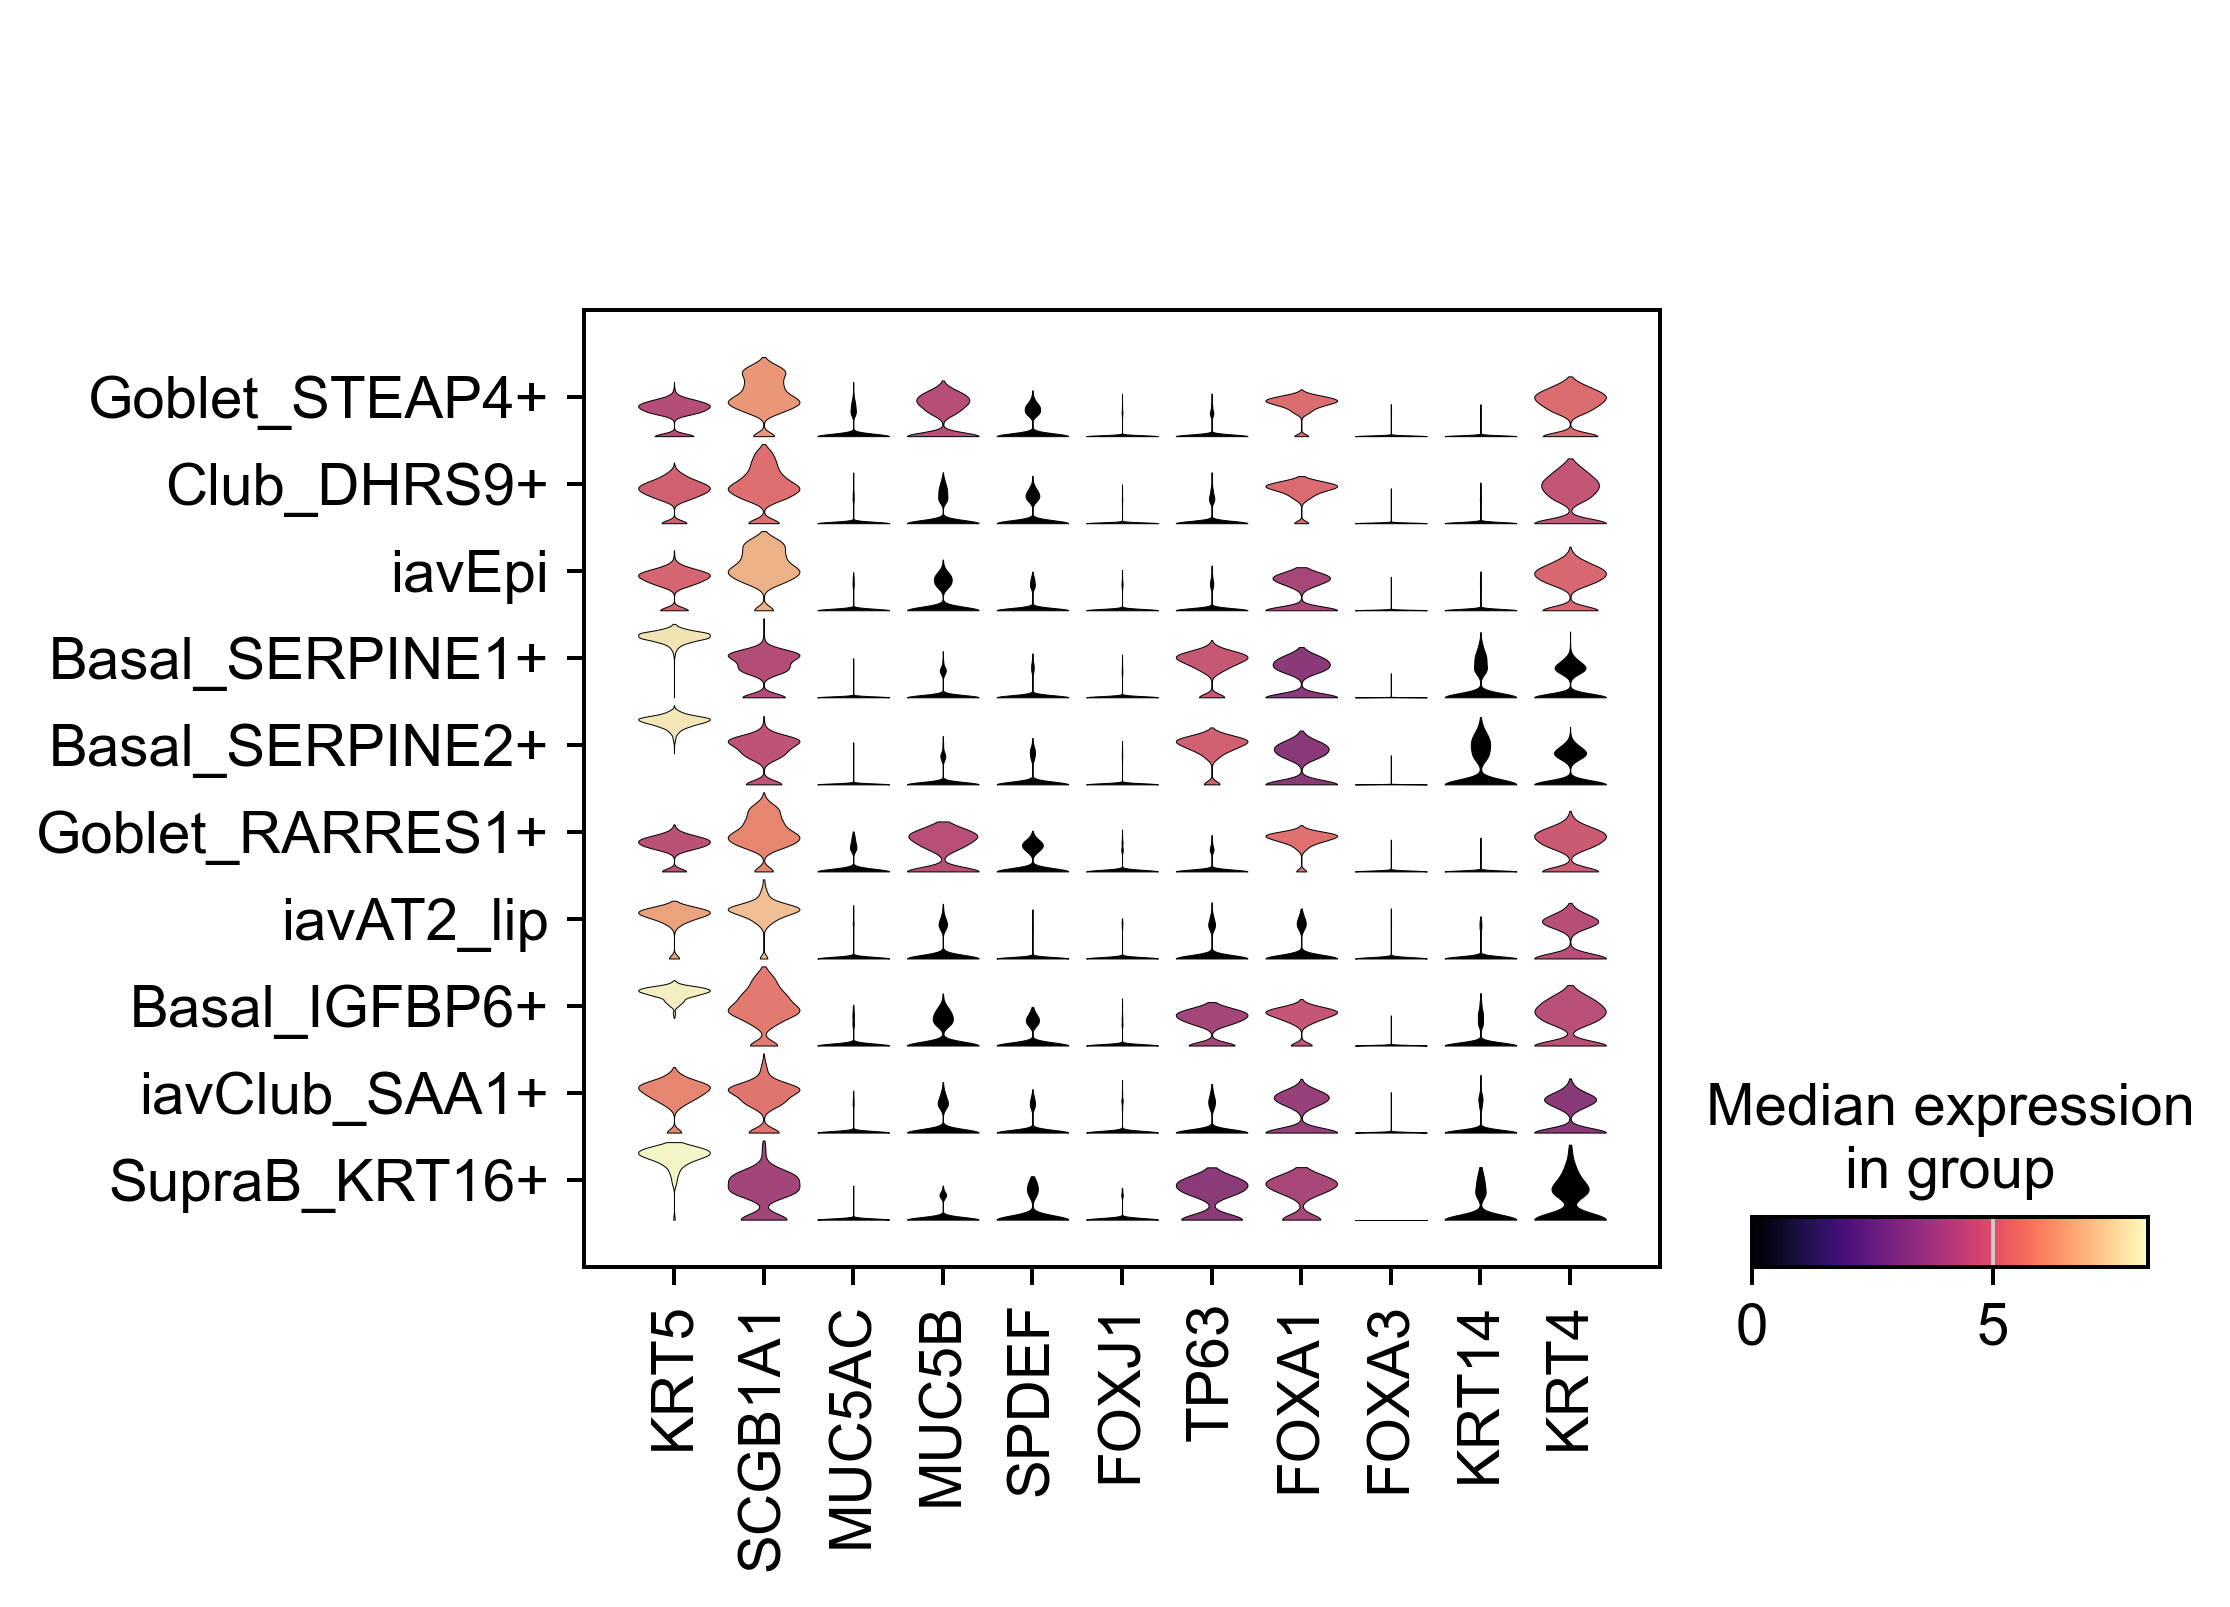

In [14]:
markers = ['KRT5', 'SCGB1A1', 'MUC5AC', 'MUC5B', 'SPDEF', 'FOXJ1', 'TP63', 'FOXA1', 'FOXA3', 'KRT14', 'KRT4']
sc.pl.stacked_violin(epith_mixed_log, markers, groupby = 'mixed_states', cmap = 'magma')

In [10]:
sc.tl.rank_genes_groups(epith_mixed_log, 'mixed_states', method = 'wilcoxon', n_genes = 100, use_raw = False)
result = epith_mixed_log.uns['rank_genes_groups']
groups = result['names'].dtype.names
wilcox_markers = pd.DataFrame(
{group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names','logfoldchanges', 'pvals_adj']})
wilcox_markers.head(10)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:39)


,Goblet_STEAP4+_n,Goblet_STEAP4+_l,Goblet_STEAP4+_p,Club_DHRS9+_n,Club_DHRS9+_l,Club_DHRS9+_p,iavEpi_n,iavEpi_l,iavEpi_p,Basal_SERPINE1+_n,...,iavAT2_lip_p,Basal_IGFBP6+_n,Basal_IGFBP6+_l,Basal_IGFBP6+_p,iavClub_SAA1+_n,iavClub_SAA1+_l,iavClub_SAA1+_p,SupraB_KRT16+_n,SupraB_KRT16+_l,SupraB_KRT16+_p
0,PIGR,4.295747,0.0,DHRS9,3.679323,0.000000e+00,NC_026432.1,7.682601,0.0,COL17A1,...,0.0,S100A2,2.956441,3.448878e-298,NC_026432.1,7.056618,3.816144e-270,KRT6A,5.096785,9.560350e-122
1,BPIFB1,3.730842,0.0,EPAS1,2.938041,0.000000e+00,NC_026433.1,7.463603,0.0,LAMC2,...,0.0,RPL23,1.119971,2.162988e-277,NC_026436.1,6.761733,3.367932e-258,PERP,1.887576,8.725282e-107
2,C3,3.101190,0.0,GSN,1.807749,0.000000e+00,NC_026436.1,7.331838,0.0,LAMA3,...,0.0,KRT5,3.648566,4.594234e-271,NC_026434.1,7.182007,2.489473e-256,IL1RN,4.352706,1.630488e-105
3,CD74,2.653651,0.0,IGFBP3,2.262553,0.000000e+00,NC_026431.1,7.120830,0.0,ACTN1,...,0.0,RPL6,1.009606,5.736239e-252,NC_026433.1,6.843603,6.271659e-256,KRT17,3.956059,4.721424e-85
4,XBP1,2.574289,0.0,FAM83A,2.175002,0.000000e+00,NC_026434.1,7.570934,0.0,SERPINE1,...,0.0,RPS8,0.953742,1.569905e-243,NC_026431.1,6.483793,1.707206e-249,DSG3,5.109089,5.081772e-84
5,CP,3.869267,0.0,ID1,2.222511,0.000000e+00,NC_026437.1,7.313586,0.0,LAMB3,...,0.0,KRT15,3.466575,1.763570e-240,NC_026437.1,6.803233,8.430957e-247,KRT5,3.499279,5.261368e-83
6,STEAP4,4.443233,0.0,B4GALT5,2.610563,0.000000e+00,NC_026438.1,7.246980,0.0,MT2A,...,0.0,AQP3,2.648463,1.075559e-236,NC_026435.1,6.370066,8.591884e-242,S100A16,2.169460,5.261368e-83
7,CYP4B1,3.985442,0.0,GLUL,1.945926,2.034344e-295,NC_026435.1,6.908510,0.0,CAVIN1,...,0.0,RPL41,0.861461,1.131053e-236,NC_026438.1,6.646149,1.666586e-237,DSP,2.695634,2.293232e-82
8,SCNN1A,2.846596,0.0,OAS2,2.921410,2.671558e-293,MT-CO2,0.991109,0.0,SFN,...,0.0,IGFBP6,5.215909,4.333804e-235,FTH1,1.309613,2.372957e-231,SERPINB5,4.167644,6.418013e-80
9,SCGB3A1,3.208201,0.0,KRT19,1.157191,1.140902e-288,MT-CO3,1.001796,0.0,KRT17,...,0.0,RPS29,0.870150,2.855471e-231,CXCL8,3.966595,1.533108e-191,MT1X,1.832458,7.207884e-80


In [11]:
wilcox_markers.to_csv('Epithelial_Mixed_ctl230608_mixed_states_WilcoxRST_markers.csv', sep = ',', index = False)

In [ ]:
sc.pl.umap(epith_mixed, frameon = False, color = ['leiden', 'C_scANVI', 'C_scANVI_v2'], size = 2.5, legend_fontsize = 5, ncols = 3, legend_loc = 'on data')

In [ ]:
epith_mixed.obs['leiden'].cat.categories

In [ ]:
epith_mixed.obs['mixed_states'] = epith_mixed.obs['leiden']
epith_mixed.obs['mixed_states'].cat.categories = ['Goblet_STEAP4+', 'Club_DHRS9+', 'iavEpi', 'Basal_SERPINE1+', 'Basal_SERPINE2+', 'Goblet_RARRES1+', 'iavAT2_lip', 'Basal_IGFBP6+', 'iavClub_SAA1+', 'SupraB_KRT16+']
sc.pl.umap(epith_mixed, frameon = False, color = ['leiden', 'mixed_states', 'C_scANVI', 'C_scANVI_v2'], size = 2.5, legend_fontsize = 7, ncols = 4, legend_loc = 'on data')

In [ ]:
sc.pl.umap(epith_mixed, frameon = False, color = ['leiden', 'mixed_states', 'infection', 'group'], size = 3, legend_fontsize = 6, ncols = 4)

In [ ]:
ax1 = pd.crosstab(epith_mixed.obs['group'], epith_mixed.obs['mixed_states']).plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (10,6), fontsize = 12, grid = False)
horiz_offset = 1.03
vert_offset = 1.0
ax1.legend(bbox_to_anchor = (horiz_offset, vert_offset), ncol = 2)

In [ ]:
data = pd.crosstab(epith_mixed.obs['group'], epith_mixed.obs['mixed_states'])
totals = data.sum(axis = 1)
percent = data.div(totals, axis = 0).mul(100).round(2)

ax1 = percent.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (16,8), fontsize = 10, grid = False, width = 0.6)
horiz_offset = 1.0
vert_offset = 1.0
ax1.legend(bbox_to_anchor = (horiz_offset, vert_offset), ncol = 1)

for c in ax1.containers:
    
    # custom label calculates percent and add an empty string so 0 value bars don't have a number
    labels = [f'{w:0.2f}%' if (w := v.get_width()) > 0 else '' for v in c]
    
    # add annotations
    ax1.bar_label(c, labels = labels, label_type = 'center', padding = 1, color = 'black', rotation = 270, fontsize = 6)

### Export annotated sample object 

In [ ]:
epith_mixed.obs.index = pd.Index(['-'.join(idx.split('-')[:3]) for idx in epith_mixed.obs.index])
epith_mixed.obs.index

In [ ]:
epith_mixed.obs['C_scANVI_v2'].cat.categories

In [ ]:
epith_mixed.obs['mixed_states'].value_counts()

### Export annotated object with raw counts

In [ ]:
epith_mixed.write('/Volumes/F-104/nobackup/raw_data/single_cell/COPD_IAV/working_objects/cellstates/mixed/Epithelial_Mixed_ctl230608_states.raw.h5ad')